In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.sql import text

import baikalfunctions as bfunc
import scheme_mar2023 as scheme

In [160]:
# pd.set_option('display.min_rows', 100)
%matplotlib inline
plt.style.use('Solarize_Light2')   # try another styles: 'classic'
plt.rcParams['figure.figsize'] = [15, 5]
plt.subplots_adjust(top=1, left=0, right=1, bottom=0)

<Figure size 1500x500 with 0 Axes>

In [161]:
saveImgPath = 'C:\\xampp\\htdocs\\img\\'

In [162]:
# host = 192.168.3.53
host = 'localhost'
tableName = "jun2023sea"

engine = create_engine(f"mysql+pymysql://root:oceana1777@{host}:3306/baikal")
#req = f"select * from {tableName} where DateTime > ADDDATE((SELECT DATETIME FROM {tableName} ORDER BY " \
#      f"DATETIME DESC LIMIT 1), INTERVAL -24 hour);"
req = f"select * from {tableName}"

In [163]:
with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(req))
df = pd.DataFrame(query.fetchall())
df.tail(5)

,DateTime,Comments,SPEED,SPEED_err,COURSE,COURSE_err,V1_state,V1_state_err,V2_state,V2_state_err,...,KFA_R,KFA_R_err,NX_G,NX_G_err,NX_B,NX_B_err,KFA_B,KFA_B_err,KFA_G,KFA_G_err
13097,2023-06-07 16:48:20,None,0.131938,0.054356,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13098,2023-06-07 16:48:40,None,0.098062,0.034615,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13099,2023-06-07 16:49:00,None,0.116733,0.037189,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13100,2023-06-07 16:49:20,None,0.114625,0.069643,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13101,2023-06-07 16:49:40,None,0.140188,0.060553,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
df.shape[0]

13102

In [165]:
df.rename(columns=scheme.NAME_CONV_BAS, inplace=True)
df.sort_values(by='DateTime', inplace=True)
df.reset_index(inplace=True, drop=True)
df.tail(2)

,DateTime,Comments,SPEED,SPEED_err,COURSE,COURSE_err,V1_state,V1_state_err,V2_state,V2_state_err,...,KFA_R,KFA_R_err,NX_G,NX_G_err,NX_B,NX_B_err,KFA_B,KFA_B_err,KFA_G,KFA_G_err
13100,2023-06-07 16:49:20,None,0.114625,0.069643,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13101,2023-06-07 16:49:40,None,0.140188,0.060553,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
df.columns

Index(['DateTime', 'Comments', 'SPEED', 'SPEED_err', 'COURSE', 'COURSE_err',
       'V1_state', 'V1_state_err', 'V2_state', 'V2_state_err', 'V3_state',
       'V3_state_err', 'V4_state', 'V4_state_err', 'V5_state', 'V5_state_err',
       'V6_state', 'V6_state_err', 'V7_state', 'V7_state_err', 'V8_state',
       'V8_state_err', 'PUMP_PROBE_state', 'PUMP_PROBE_state_err',
       'PUMP_VENTILATION_state', 'PUMP_VENTILATION_state_err', 'AirFlow',
       'AIR_FLOW_err', 'TempAir', 'AIR_TEMPERATURE_err', 'PressAir',
       'AIR_PRESSURE_err', 'RAIN', 'RAIN_err', 'LightLX', 'LIGHT_LX_err',
       'LightUV', 'UV_err', 'Latitude', 'LATITUDE_err', 'Longitude',
       'LONGITUDE_err', 'WaterFlowEqu1', 'WATER_FLOW_1_err', 'WaterFlowEqu2',
       'WATER_FLOW_2_err', 'WaterFlowEqu3', 'WATER_FLOW_3_err', 'TempEqu1',
       'EKV_1_TEMP_err', 'TempEqu2', 'EKV_2_TEMP_err', 'TempEqu3',
       'EKV_3_TEMP_err', 'EKV_4_TEMP', 'EKV_4_TEMP_err', 'vCO2', 'vCO2Err',
       'vCH4', 'vCH4Err', 'vH2O', 'vH2OErr',

In [167]:
## gether/apply specific variables
### data corrections
df['vCO2'] = df['vCO2'] * scheme.CO2PicarroScaut_cor[0] + scheme.CO2PicarroScaut_cor[1]
df['vCH4'] = df['vCH4'] * scheme.CH4PicarroScaut_cor[0] + scheme.CH4PicarroScaut_cor[1]
df['LightLX'] = df['LightLX'] * scheme.solar_cor[0] + scheme.solar_cor[1]
df['LightUV'] = df['LightUV'] * scheme.solar_uv_cor[0] + scheme.solar_uv_cor[1]
df['PressAir'] = bfunc.pressConvert(df['PressAir'])
df['PressAir'] = df['PressAir'] * scheme.press_cor[0] + scheme.press_cor[1]

### servise data corrections
df['TempEqu1'] = df['TempEqu1'] * scheme.tempEqu1_cor_m[0] + scheme.tempEqu1_cor_m[1]
df['TempEqu2'] = df['TempEqu2'] * scheme.tempEqu2_cor_m[0] + scheme.tempEqu2_cor_m[1]
df['TempEqu3'] = df['TempEqu3'] * scheme.tempEqu3_cor_m[0] + scheme.tempEqu3_cor_m[1]

df['AirFlow'] = df['AirFlow'] * scheme.airflow_cor_m[0] + scheme.airflow_cor_m[1]
df['WaterFlowEqu1'] = df['WaterFlowEqu1'] * scheme.waterflowEqu1_cor_m[0] + scheme.waterflowEqu1_cor_m[1]
df['WaterFlowEqu2'] = df['WaterFlowEqu2'] * scheme.waterflowEqu2_cor_m[0] + scheme.waterflowEqu2_cor_m[1]
df['WaterFlowEqu3'] = df['WaterFlowEqu3'] * scheme.waterflowEqu3_cor_m[0] + scheme.waterflowEqu3_cor_m[1]

In [168]:
chnl = 'channel'
if not chnl in df.columns:
    df[chnl] = 0
df[chnl] = 0
df.loc[df.V1_state == 1, chnl] = 1
df.loc[df.V2_state == 1, chnl] = 2
df.loc[df.V3_state == 1, chnl] = 3
df.loc[df.V4_state == 1, chnl] = 4
df.loc[df.V5_state == 1, chnl] = 5
df.loc[df.V6_state == 1, chnl] = 6

ch_v = 'chn_valid'
if not ch_v in df.columns:
    df[ch_v] = 1
df[ch_v] = 1
for deep in range(1, 7):
    df.loc[df[chnl] != df[chnl].shift(deep), ch_v] = 0

In [169]:
df['vCO2air'] = df['vCO2'][(df['channel'] == 6) & (df[ch_v] == 1)]
df['vCH4air'] = df['vCH4'][(df['channel'] == 6) & (df[ch_v] == 1)]
df['vCO2air'].fillna(method='ffill', axis='index', inplace=True)
df['vCH4air'].interpolate(method='values', inplace=True)  ## `time` method mb better
df['pCO2air'] = df['vCO2air'] * df['PressAir']  # mkatm
df['pCH4air'] = df['vCH4air'] * df['PressAir']  # mkatm

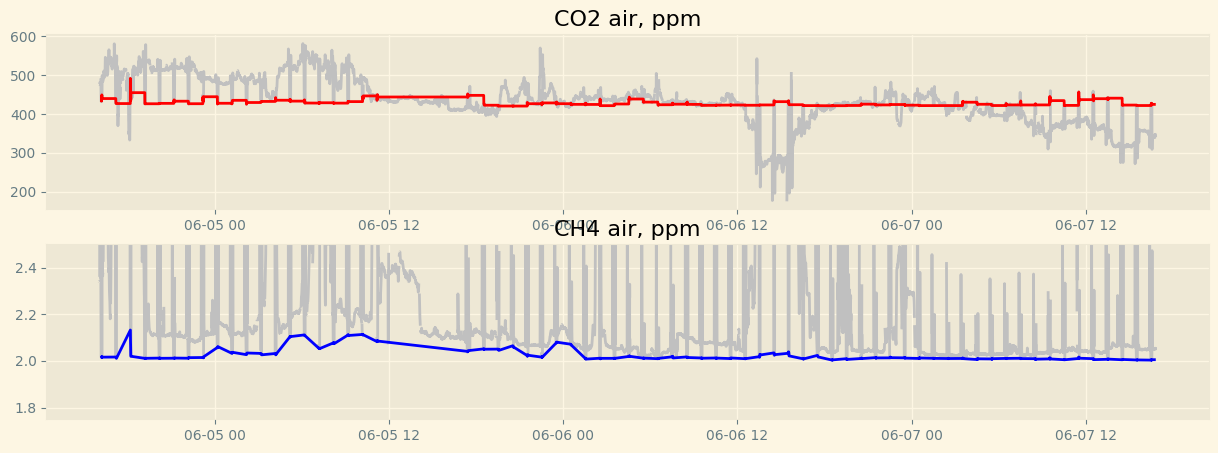

In [170]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(2, 1)

axs[0].set_title('CO2 air, ppm')
axs[0].plot(df.DateTime, df['vCO2'], '-', c='silver')
axs[0].plot(df.DateTime, df['vCO2air'], 'r-')

axs[1].set_title('CH4 air, ppm')
axs[1].set_ylim(1.75, 2.5)
axs[1].plot(df.DateTime, df['vCH4'], '-', c='silver')
axs[1].plot(df.DateTime, df['vCH4air'], 'b-')
fig.savefig(saveImgPath+'cAir_vs_time.png')

In [171]:
## RECOVERY HERE !!!
equ_vol = scheme.equ_seatube_param['equ_vol']  # equivalent equ volume, l
equ_cap = scheme.equ_seatube_param['equ_cap']  # equilibrator capacity
df['DateSec'] = df['DateTime'].astype('int64')//10**9
df['dTSec'] = df['DateSec'] - df['DateSec'].shift(1)
dt = df['dTSec'] / 60   ## delta time, min
t_wtr = df['TempEqu1']
t_air = t_wtr
air_flow = df['AirFlow']
wtr_flow = df['WaterFlowEqu1']

In [172]:
### CO2 water
df['vCO2equ1'] = df['vCO2'][(df['channel'] == 1) & (df[ch_v] == 1)]
solubility = bfunc.getSolubility(df['TempEqu1'], 'CO2')

density = bfunc.getDensity(t_air, df['PressAir'], 'CO2')
cGasAir = df['pCO2air'] / 1000000 * density
pGasEquAir = df['vCO2equ1'] * df['PressAir']
cGasEquAir = pGasEquAir * density / 1000000  # g/l

tau = equ_vol/(air_flow+wtr_flow*equ_cap*solubility/density)
eternal = (cGasEquAir-cGasEquAir.shift(1)*np.exp(-1*dt/tau))/(1-np.exp(-1*dt/tau))
cGasWtr = (eternal*(wtr_flow*equ_cap*solubility/density+air_flow)-air_flow*cGasAir)/(wtr_flow*equ_cap)
df['cCO2wtr'] = cGasWtr * 1000     # mg/l
df['pCO2wtr'] = cGasWtr * 1000000 / solubility  # mkatm

In [173]:
### CH4 water
df['vCH4equ1'] = df['vCH4'][(df['channel'] == 1) & (df[ch_v] == 1)]
solubility = bfunc.getSolubility(df['TempEqu1'], 'CH4')

density = bfunc.getDensity(t_air, df['PressAir'], 'CH4')
cGasAir = df['pCH4air'] / 1000000 * density
pGasEquAir = df['vCH4equ1'] * df['PressAir']
cGasEquAir = pGasEquAir * density / 1000000  # g/l

tau = equ_vol/(air_flow+wtr_flow*equ_cap*solubility/density)
eternal = (cGasEquAir-cGasEquAir.shift(1)*np.exp(-1*dt/tau))/(1-np.exp(-1*dt/tau))
cGasWtr = (eternal*(wtr_flow*equ_cap*solubility/density+air_flow)-air_flow*cGasAir)/(wtr_flow*equ_cap)
df['cCH4wtr'] = cGasWtr * 1000000000    # ng/l
df['pCH4wtr'] = cGasWtr * 1000000 / solubility  # mkatm

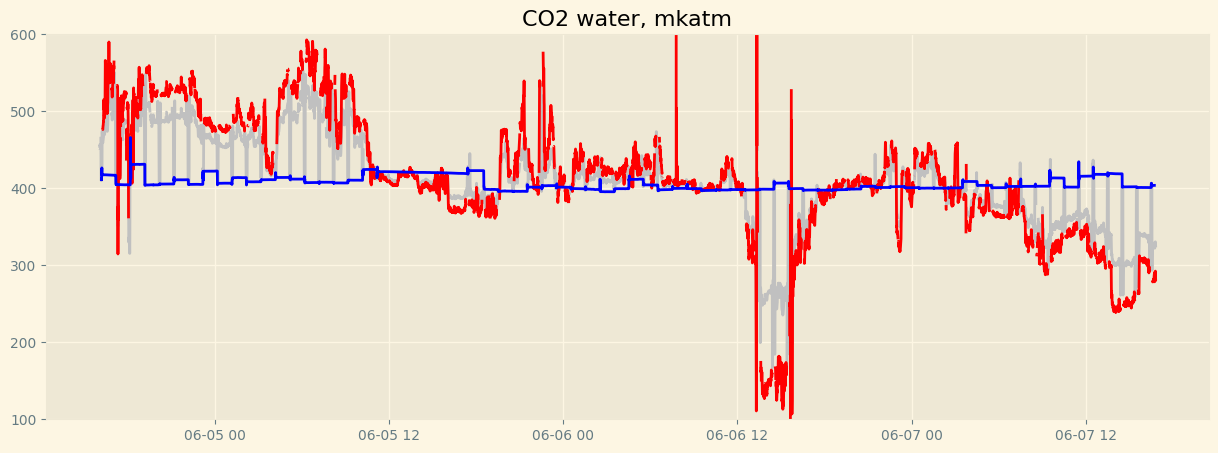

In [174]:
df['pCO2'] = df['vCO2'] * df['PressAir']

plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()
## ax.set_xlim(pd.to_datetime('05.06.2023 18:00:00', dayfirst=True), pd.to_datetime('05.06.2023 19:00:00', dayfirst=True))
ax.set_title('CO2 water, mkatm')
ax.set_ylim(100, 600)
ax.plot(df.DateTime, df['pCO2'], '-', c='silver')
ax.plot(df.DateTime, df['pCO2wtr'], 'r-')
ax.plot(df.DateTime, df['pCO2air'], 'b-')
fig.savefig(saveImgPath+'pCO2wtr_vs_time.png')

In [175]:
df['cCO2wtr'].replace(np.infty, np.NaN)

df['cCO2wtr'].describe()

count    9861.000000
mean             NaN
std              NaN
min             -inf
25%         1.115650
50%         1.223651
75%         1.371135
max              inf
Name: cCO2wtr, dtype: float64

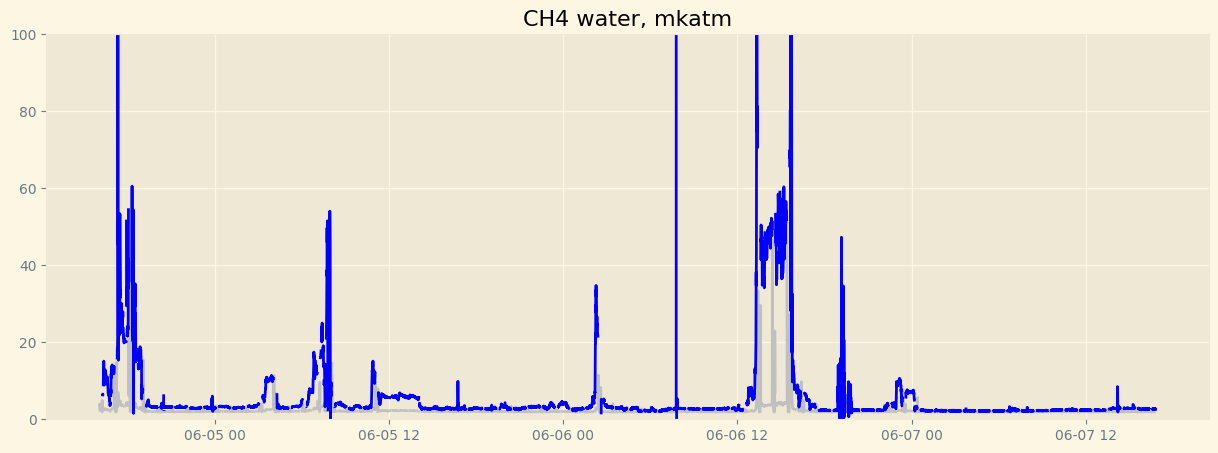

In [176]:
df['pCH4'] = df['vCH4'] * df['PressAir']

plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()
ax.set_title('CH4 water, mkatm')
# ax.set_xlim(pd.to_datetime('06.06.2023 10:00:00', dayfirst=True), pd.to_datetime('06.06.2023 19:00:00', dayfirst=True))
ax.set_ylim(0, 100)
ax.plot(df.DateTime, df['pCH4'], '-', c='silver')
ax.plot(df.DateTime, df['pCH4wtr'], 'b-')
fig.savefig(saveImgPath+'pCH4wtr_vs_time.png')

In [177]:
obrisData = "G:/1_Data1/obris/obris.dat"
obris = pd.read_csv(obrisData,
                    header=0,
                    na_values='--',
                    sep='\t',
                    decimal=',',
                    )
obris.head(3)

,i,long,lat
0,1,NaN,NaN
1,2,109.004,53.667
2,3,109.008,53.665


In [178]:
allMethaneData = "G:/1_Data1/sea/AllSeaGisOut.txt"
colNames = ['i', 'long', 'lat', 'cCH4wtr']
allMethane_df = pd.read_csv(allMethaneData,
                            index_col =0,
                            sep='\t',
                            skiprows=[0, 1, 2],
                            usecols=[0, 1, 2, 3],
                            header=None,
                            names=colNames,
                           )
allMethane_df.head(5)

,long,lat,cCH4wtr
i,,,
0,103.75,51.695,120.548499
1,103.76,51.690,123.197871
2,103.76,51.695,114.449653
3,103.77,51.690,119.207194
4,103.77,51.695,107.322251


C:\Users\pestu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


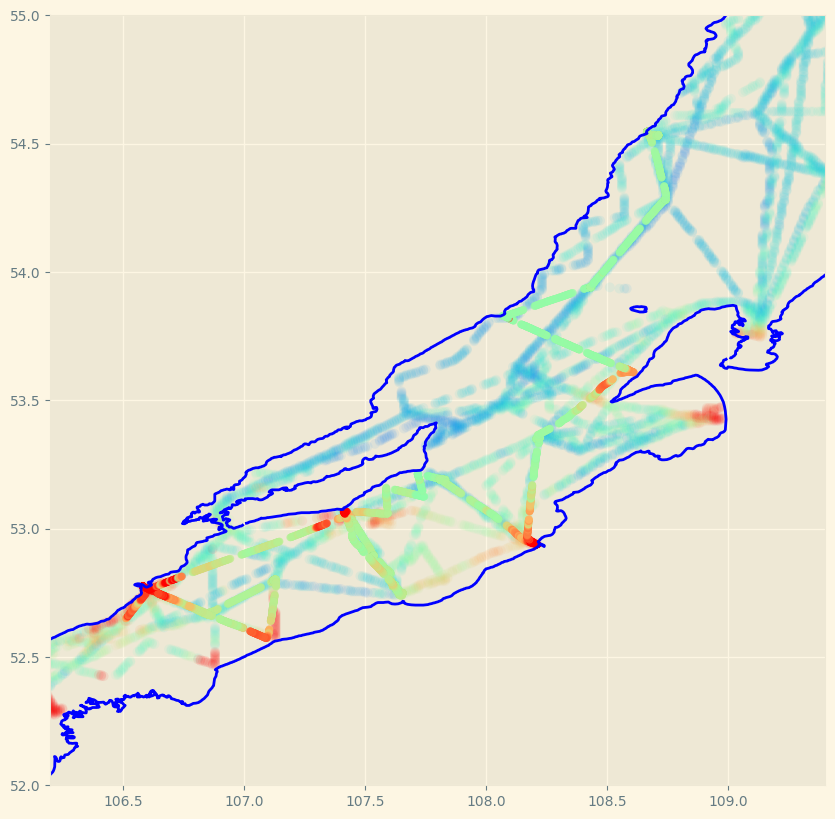

In [179]:
df.dropna(axis='index', subset=['Longitude', 'Latitude', 'cCH4wtr'], inplace=True)

cCH2lim = 700
df.loc[df.cCH4wtr > cCH2lim, 'cCH4wtr'] = cCH2lim
allMethane_df.loc[allMethane_df.cCH4wtr > cCH2lim, 'cCH4wtr'] = cCH2lim


cCH4wtrlog_all = np.log(allMethane_df['cCH4wtr'])
cCH4wtrlog = np.log(df['cCH4wtr'])

plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
ax.set_xlim(106.2, 109.4)
ax.set_ylim(52, 55)

ax.plot(obris['long'], obris['lat'], 'b-')
ax.scatter(x='long', y='lat', c=cCH4wtrlog_all, s=50, marker='o', linewidth=0, cmap='rainbow', alpha=0.08, data=allMethane_df, )
ax.scatter(df['Longitude'], df['Latitude'], c=cCH4wtrlog, s=30, marker='o', linewidth=0, cmap='rainbow', alpha=0.4,)
fig.savefig(saveImgPath+'CH4wtrSpatialJun2023.png')


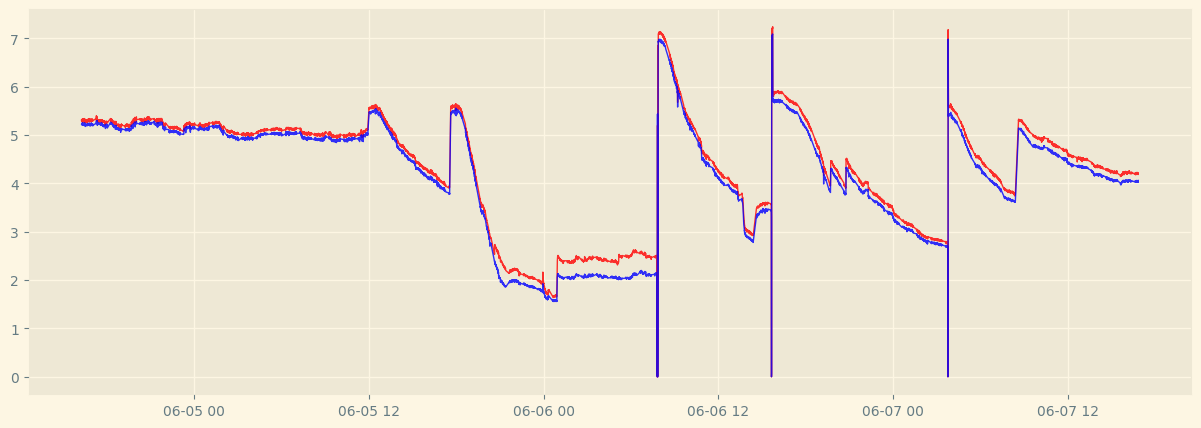

In [192]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()

ax.plot('DateTime', 'WaterFlowEqu1', 'r-', linewidth=1, alpha=0.8, data=df, )
ax.plot('DateTime', 'WaterFlowEqu2', 'b-', linewidth=1, alpha=0.8, data=df, )
fig.savefig(saveImgPath+'sWaterFlow.png')


In [186]:
col_list = ['DateTime', 'Latitude', 'Longitude', 'SPEED', 'COURSE', 'TempAir', 'PressAir', 'RAIN', 'LightLX', 'LightUV', 'WaterFlowEqu1', 'WaterFlowEqu2',
            'TempEqu1', 'TempEqu2', 'vCO2', 'vCO2Err', 'vCH4', 'vCH4Err', 'vH2O', 'vH2OErr', 'NX_R', 'KFA_R', 'NX_G', 'NX_B', 'KFA_B', 'KFA_G', 
            'vCO2air', 'vCH4air', 'pCO2air', 'pCH4air', 'cCO2wtr', 'pCO2wtr', 'cCH4wtr', 'pCH4wtr', 'pCO2', 'pCH4' ]
df[col_list].to_csv('1.txt',
                    sep='\t',
                   )

In [184]:
l = df.columns
l

Index(['DateTime', 'Comments', 'SPEED', 'SPEED_err', 'COURSE', 'COURSE_err',
       'V1_state', 'V1_state_err', 'V2_state', 'V2_state_err', 'V3_state',
       'V3_state_err', 'V4_state', 'V4_state_err', 'V5_state', 'V5_state_err',
       'V6_state', 'V6_state_err', 'V7_state', 'V7_state_err', 'V8_state',
       'V8_state_err', 'PUMP_PROBE_state', 'PUMP_PROBE_state_err',
       'PUMP_VENTILATION_state', 'PUMP_VENTILATION_state_err', 'AirFlow',
       'AIR_FLOW_err', 'TempAir', 'AIR_TEMPERATURE_err', 'PressAir',
       'AIR_PRESSURE_err', 'RAIN', 'RAIN_err', 'LightLX', 'LIGHT_LX_err',
       'LightUV', 'UV_err', 'Latitude', 'LATITUDE_err', 'Longitude',
       'LONGITUDE_err', 'WaterFlowEqu1', 'WATER_FLOW_1_err', 'WaterFlowEqu2',
       'WATER_FLOW_2_err', 'WaterFlowEqu3', 'WATER_FLOW_3_err', 'TempEqu1',
       'EKV_1_TEMP_err', 'TempEqu2', 'EKV_2_TEMP_err', 'TempEqu3',
       'EKV_3_TEMP_err', 'EKV_4_TEMP', 'EKV_4_TEMP_err', 'vCO2', 'vCO2Err',
       'vCH4', 'vCH4Err', 'vH2O', 'vH2OErr',

In [181]:
df.cCH4wtr.dropna().describe()

count    9655.000000
mean            -inf
std              NaN
min             -inf
25%        93.607402
50%       108.635133
75%       148.115026
max       700.000000
Name: cCH4wtr, dtype: float64